In [4]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Define the target model architecture
class CustomResNet(torch.nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=False)  # Or use your model architecture
        # Replace the last fully connected layer with one for CIFAR-10
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Define the target model (loading your PyTorch model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomResNet().to(device)
model.load_state_dict(torch.load('cifar10-resnet34_8x.pt', map_location=device))

model.eval()

# FGSM Attack function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Generate adversarial examples
def generate_adversarial_examples(input_image, input_label, epsilon=0.04):
    input_image = input_image.to(device)
    input_label = input_label.to(device)

    input_image.requires_grad = True
    output = model(input_image)
    loss = torch.nn.functional.cross_entropy(output, input_label)
    model.zero_grad()
    loss.backward()

    data_grad = input_image.grad.data
    perturbed_image = fgsm_attack(input_image, epsilon, data_grad)
    return perturbed_image

# Create a directory to store the attacker dataset
attacker_dir = 'attacker_dataset'
os.makedirs(attacker_dir, exist_ok=True)

# Create the attacker dataset
attacker_images = []
attacker_labels = []

epsilon = 0.04  # Adjust epsilon value as needed

for i, (input_image, input_label) in enumerate(testloader):
    # Generate adversarial example
    perturbed_image = generate_adversarial_examples(input_image, input_label, epsilon)

    attacker_images.append(perturbed_image.cpu().detach().numpy())
    attacker_labels.append(input_label.item())

attacker_images = np.array(attacker_images)
attacker_labels = np.array(attacker_labels)

# Save the attacker dataset images
for i in range(len(attacker_images)):
    image = attacker_images[i]
    label = attacker_labels[i]

    # Convert the image array back to PIL image
    image_pil = Image.fromarray(((image.transpose(1, 2, 0) + 1) * 127.5).astype(np.uint8))

    # Save the image with the label as part of the filename
    image_filename = os.path.join(attacker_dir, 'attacker_image_{}_label_{}.png'.format(i, label))
    image_pil.save(image_filename)

# Save attacker dataset labels to a text file
labels_filename = os.path.join(attacker_dir, 'attacker_labels.txt')
np.savetxt(labels_filename, attacker_labels, fmt='%d')

print("Attacker dataset saved in directory:", attacker_dir)


100%|████████████████████████| 170498071/170498071 [01:12<00:00, 2344082.71it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


RuntimeError: Error(s) in loading state_dict for CustomResNet:
	Missing key(s) in state_dict: "resnet.conv1.weight", "resnet.bn1.weight", "resnet.bn1.bias", "resnet.bn1.running_mean", "resnet.bn1.running_var", "resnet.layer1.0.conv1.weight", "resnet.layer1.0.bn1.weight", "resnet.layer1.0.bn1.bias", "resnet.layer1.0.bn1.running_mean", "resnet.layer1.0.bn1.running_var", "resnet.layer1.0.conv2.weight", "resnet.layer1.0.bn2.weight", "resnet.layer1.0.bn2.bias", "resnet.layer1.0.bn2.running_mean", "resnet.layer1.0.bn2.running_var", "resnet.layer1.1.conv1.weight", "resnet.layer1.1.bn1.weight", "resnet.layer1.1.bn1.bias", "resnet.layer1.1.bn1.running_mean", "resnet.layer1.1.bn1.running_var", "resnet.layer1.1.conv2.weight", "resnet.layer1.1.bn2.weight", "resnet.layer1.1.bn2.bias", "resnet.layer1.1.bn2.running_mean", "resnet.layer1.1.bn2.running_var", "resnet.layer1.2.conv1.weight", "resnet.layer1.2.bn1.weight", "resnet.layer1.2.bn1.bias", "resnet.layer1.2.bn1.running_mean", "resnet.layer1.2.bn1.running_var", "resnet.layer1.2.conv2.weight", "resnet.layer1.2.bn2.weight", "resnet.layer1.2.bn2.bias", "resnet.layer1.2.bn2.running_mean", "resnet.layer1.2.bn2.running_var", "resnet.layer2.0.conv1.weight", "resnet.layer2.0.bn1.weight", "resnet.layer2.0.bn1.bias", "resnet.layer2.0.bn1.running_mean", "resnet.layer2.0.bn1.running_var", "resnet.layer2.0.conv2.weight", "resnet.layer2.0.bn2.weight", "resnet.layer2.0.bn2.bias", "resnet.layer2.0.bn2.running_mean", "resnet.layer2.0.bn2.running_var", "resnet.layer2.0.downsample.0.weight", "resnet.layer2.0.downsample.1.weight", "resnet.layer2.0.downsample.1.bias", "resnet.layer2.0.downsample.1.running_mean", "resnet.layer2.0.downsample.1.running_var", "resnet.layer2.1.conv1.weight", "resnet.layer2.1.bn1.weight", "resnet.layer2.1.bn1.bias", "resnet.layer2.1.bn1.running_mean", "resnet.layer2.1.bn1.running_var", "resnet.layer2.1.conv2.weight", "resnet.layer2.1.bn2.weight", "resnet.layer2.1.bn2.bias", "resnet.layer2.1.bn2.running_mean", "resnet.layer2.1.bn2.running_var", "resnet.layer2.2.conv1.weight", "resnet.layer2.2.bn1.weight", "resnet.layer2.2.bn1.bias", "resnet.layer2.2.bn1.running_mean", "resnet.layer2.2.bn1.running_var", "resnet.layer2.2.conv2.weight", "resnet.layer2.2.bn2.weight", "resnet.layer2.2.bn2.bias", "resnet.layer2.2.bn2.running_mean", "resnet.layer2.2.bn2.running_var", "resnet.layer2.3.conv1.weight", "resnet.layer2.3.bn1.weight", "resnet.layer2.3.bn1.bias", "resnet.layer2.3.bn1.running_mean", "resnet.layer2.3.bn1.running_var", "resnet.layer2.3.conv2.weight", "resnet.layer2.3.bn2.weight", "resnet.layer2.3.bn2.bias", "resnet.layer2.3.bn2.running_mean", "resnet.layer2.3.bn2.running_var", "resnet.layer3.0.conv1.weight", "resnet.layer3.0.bn1.weight", "resnet.layer3.0.bn1.bias", "resnet.layer3.0.bn1.running_mean", "resnet.layer3.0.bn1.running_var", "resnet.layer3.0.conv2.weight", "resnet.layer3.0.bn2.weight", "resnet.layer3.0.bn2.bias", "resnet.layer3.0.bn2.running_mean", "resnet.layer3.0.bn2.running_var", "resnet.layer3.0.downsample.0.weight", "resnet.layer3.0.downsample.1.weight", "resnet.layer3.0.downsample.1.bias", "resnet.layer3.0.downsample.1.running_mean", "resnet.layer3.0.downsample.1.running_var", "resnet.layer3.1.conv1.weight", "resnet.layer3.1.bn1.weight", "resnet.layer3.1.bn1.bias", "resnet.layer3.1.bn1.running_mean", "resnet.layer3.1.bn1.running_var", "resnet.layer3.1.conv2.weight", "resnet.layer3.1.bn2.weight", "resnet.layer3.1.bn2.bias", "resnet.layer3.1.bn2.running_mean", "resnet.layer3.1.bn2.running_var", "resnet.layer3.2.conv1.weight", "resnet.layer3.2.bn1.weight", "resnet.layer3.2.bn1.bias", "resnet.layer3.2.bn1.running_mean", "resnet.layer3.2.bn1.running_var", "resnet.layer3.2.conv2.weight", "resnet.layer3.2.bn2.weight", "resnet.layer3.2.bn2.bias", "resnet.layer3.2.bn2.running_mean", "resnet.layer3.2.bn2.running_var", "resnet.layer3.3.conv1.weight", "resnet.layer3.3.bn1.weight", "resnet.layer3.3.bn1.bias", "resnet.layer3.3.bn1.running_mean", "resnet.layer3.3.bn1.running_var", "resnet.layer3.3.conv2.weight", "resnet.layer3.3.bn2.weight", "resnet.layer3.3.bn2.bias", "resnet.layer3.3.bn2.running_mean", "resnet.layer3.3.bn2.running_var", "resnet.layer3.4.conv1.weight", "resnet.layer3.4.bn1.weight", "resnet.layer3.4.bn1.bias", "resnet.layer3.4.bn1.running_mean", "resnet.layer3.4.bn1.running_var", "resnet.layer3.4.conv2.weight", "resnet.layer3.4.bn2.weight", "resnet.layer3.4.bn2.bias", "resnet.layer3.4.bn2.running_mean", "resnet.layer3.4.bn2.running_var", "resnet.layer3.5.conv1.weight", "resnet.layer3.5.bn1.weight", "resnet.layer3.5.bn1.bias", "resnet.layer3.5.bn1.running_mean", "resnet.layer3.5.bn1.running_var", "resnet.layer3.5.conv2.weight", "resnet.layer3.5.bn2.weight", "resnet.layer3.5.bn2.bias", "resnet.layer3.5.bn2.running_mean", "resnet.layer3.5.bn2.running_var", "resnet.layer4.0.conv1.weight", "resnet.layer4.0.bn1.weight", "resnet.layer4.0.bn1.bias", "resnet.layer4.0.bn1.running_mean", "resnet.layer4.0.bn1.running_var", "resnet.layer4.0.conv2.weight", "resnet.layer4.0.bn2.weight", "resnet.layer4.0.bn2.bias", "resnet.layer4.0.bn2.running_mean", "resnet.layer4.0.bn2.running_var", "resnet.layer4.0.downsample.0.weight", "resnet.layer4.0.downsample.1.weight", "resnet.layer4.0.downsample.1.bias", "resnet.layer4.0.downsample.1.running_mean", "resnet.layer4.0.downsample.1.running_var", "resnet.layer4.1.conv1.weight", "resnet.layer4.1.bn1.weight", "resnet.layer4.1.bn1.bias", "resnet.layer4.1.bn1.running_mean", "resnet.layer4.1.bn1.running_var", "resnet.layer4.1.conv2.weight", "resnet.layer4.1.bn2.weight", "resnet.layer4.1.bn2.bias", "resnet.layer4.1.bn2.running_mean", "resnet.layer4.1.bn2.running_var", "resnet.layer4.2.conv1.weight", "resnet.layer4.2.bn1.weight", "resnet.layer4.2.bn1.bias", "resnet.layer4.2.bn1.running_mean", "resnet.layer4.2.bn1.running_var", "resnet.layer4.2.conv2.weight", "resnet.layer4.2.bn2.weight", "resnet.layer4.2.bn2.bias", "resnet.layer4.2.bn2.running_mean", "resnet.layer4.2.bn2.running_var", "resnet.fc.weight", "resnet.fc.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.shortcut.0.weight", "layer2.0.shortcut.1.weight", "layer2.0.shortcut.1.bias", "layer2.0.shortcut.1.running_mean", "layer2.0.shortcut.1.running_var", "layer2.0.shortcut.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.shortcut.0.weight", "layer3.0.shortcut.1.weight", "layer3.0.shortcut.1.bias", "layer3.0.shortcut.1.running_mean", "layer3.0.shortcut.1.running_var", "layer3.0.shortcut.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.shortcut.0.weight", "layer4.0.shortcut.1.weight", "layer4.0.shortcut.1.bias", "layer4.0.shortcut.1.running_mean", "layer4.0.shortcut.1.running_var", "layer4.0.shortcut.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "linear.weight", "linear.bias". 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [6]:
def load_dataset(batch_size):
    # Set dataset path
    dataset_path = './data/cifar10'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                             shuffle=False, num_workers=2)

    # Class names for CIFAR-10 dataset
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # Switch to train mode
    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy
    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

In [8]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * inputs.size(0)

            # Compute test accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy


In [9]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print()

        # Save the model if the current test accuracy is higher than the best accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            checkpoint = {
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                #'optimizer_state_dict': optimizer.state_dict(),
                'test_accuracy' : test_accuracy
            }
            torch.save(checkpoint, 'best_model.pth')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [10]:
def fgsm_attack(model, criterion, images, labels, device, epsilon):
    images.requires_grad_(True)
    outputs = model(images)
    loss = criterion(outputs, labels).to(device)
    model.zero_grad()
    loss.backward()

    gradient = images.grad.data
    perturbations = epsilon * torch.sign(gradient)
    adversarial_images = images + perturbations
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images, perturbations

In [11]:
def test_adversarial(model, testloader, criterion, device, epsilon):
    adversarial_correct = 0
    attack_success = 0
    total = 0

    model.eval()

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        adversarial_images, _ = fgsm_attack(model, criterion, images, labels, device, epsilon)

        adversarial_outputs = model(adversarial_images)

        _, adversarial_predicted = torch.max(adversarial_outputs.data, 1)

        adversarial_correct += (adversarial_predicted == labels).sum().item()
        attack_success += (adversarial_predicted != labels).sum().item()
        total += labels.size(0)

    adversarial_accuracy = 100.0 * adversarial_correct / total
    attack_success_rate = 100.0 * attack_success / total
    print(f'Epsilon = {epsilon}:')
    print(f'Adversarial Accuracy: {adversarial_accuracy:.2f}%')
    print(f'Attack Success Rate: {attack_success_rate:.2f}%')
    print('------------------------------------------------------')
    return adversarial_accuracy, attack_success_rate

In [12]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()


def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()


In [13]:
def plot_image(dataset, model, classes, device):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)  # Move the input image tensor to the GPU
    model.eval()
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    # Convert the image and show it
    img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

In [14]:
def plot_adv_images(dataset, model, criterion, classes, device, epsilon):
    num_images = 4

    clean_images = []
    clean_labels = []
    for _ in range(num_images):
        index = random.randint(0, len(dataset))
        image, label = dataset[index]
        clean_images.append(image)
        clean_labels.append(label)

    clean_images = torch.stack(clean_images).to(device)
    clean_labels = torch.tensor(clean_labels).to(device)

    adversarial_images, perturbations = fgsm_attack(model, criterion, clean_images, clean_labels, device, epsilon)

    fig, axes = plt.subplots(num_images, 5, figsize=(15, 10))

    for i in range(num_images):
        clean_img = clean_images[i].cpu().permute(1, 2, 0).detach().numpy()
        perturbation = perturbations[i].cpu().permute(1, 2, 0).detach().numpy()
        adversarial_img = adversarial_images[i].cpu().permute(1, 2, 0).detach().numpy()

        axes[i, 0].imshow(clean_img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Clean: {classes[clean_labels[i]]}', fontweight='bold', color='green')

        axes[i, 1].axis('off')
        axes[i, 1].text(0.5, 0.5, '+', fontsize=40, ha='center', va='center')
        axes[i, 1].set_title('')

        axes[i, 2].imshow(perturbation)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Perturbation')

        axes[i, 3].axis('off')
        axes[i, 3].text(0.5, 0.5, '=', fontsize=40, ha='center', va='center')
        axes[i, 3].set_title('')

        axes[i, 4].imshow(adversarial_img)
        axes[i, 4].axis('off')
        axes[i, 4].set_title(f'Adversarial: {classes[model(adversarial_images[i].unsqueeze(0)).argmax().item()]}', fontweight='bold', color='red')

    plt.tight_layout()
    plt.title('Results of Generated Adversarial Examples')
    plt.savefig('Generated_Adversarial_examples.png')
    plt.show()

In [15]:
def epsilon_compare(epsilon_values, adversarial_accuracies, attack_success_rates):
    if len(epsilon_values) != len(adversarial_accuracies) or len(epsilon_values) != len(attack_success_rates):
        print("Error: Input lists have different lengths.")
        return
    plt.figure(figsize=(10, 6))

    plt.plot(epsilon_values, adversarial_accuracies, 'o-', label='Adversarial Accuracy')
    plt.plot(epsilon_values, attack_success_rates, 'o-', label='Attack Success Rate')

    for i in range(len(epsilon_values)):
        plt.text(epsilon_values[i], adversarial_accuracies[i], f"{adversarial_accuracies[i]:.2f}", ha='center', va='bottom')
        plt.text(epsilon_values[i], attack_success_rates[i], f"{attack_success_rates[i]:.2f}", ha='center', va='bottom')

    plt.xlabel('Epsilon')
    plt.ylabel('Percentage')
    plt.title('Comparison of Adversarial Accuracies and Attack Success Rates')
    plt.legend()
    plt.tight_layout()
    plt.savefig('ep_list_results')
    plt.show()

In [16]:
def main(train_model, epsilon_list):

    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    # Load the dataset
    num_classes = 10
    batch_size = 64
    trainset, trainloader, testset, testloader, classes = load_dataset(batch_size)

    # Load the pre-trained model
    model = models.resnet50(pretrained=True)
    # Modify conv1 to suit CIFAR-10
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # Modify the final fully connected layer according to the number of classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Set hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 60
    epsilon = 0.3
    epsilon_values = [0.01, 0.03, 0.07, 0.1, 0.3, 0.5]

    if train_model:
      print("Training the model...")
      # Train the model
      model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
          model, trainloader, testloader, criterion, optimizer, device, num_epochs)

      # Plot the loss and accuracy curves
      plot_loss(train_losses, test_losses)
      plot_accuracy(train_accuracies, test_accuracies)
      # Plot and save an example image
      plot_image(testset, model, classes, device)
      # Visualize some adversarial examples
      print("Generating Visualization Plot")
      plot_adv_images(testset, model, criterion, classes, device, epsilon)  
    else:
      # Load the best model
      best_model = models.resnet50(pretrained=True)
      # Modify conv1 to suit CIFAR-10
      best_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      best_model.fc = nn.Linear(num_features, num_classes)
      # Load checkpoints
      checkpoint = torch.load('best_model.pth')
      best_model.load_state_dict(checkpoint['model_state_dict'])
      epoch = checkpoint['epoch']
      test_accuracy = checkpoint['test_accuracy']
      best_model = best_model.to(device)
      print("Best Trained Model Loaded!")
      print(f"Checkpoint at Epoch {epoch+1} with accuracy of {test_accuracy}%")

      # Test the best model on adversarial examples
      if epsilon_list:
        # Evaluate adversarial attacks for each epsilon value
        adversarial_accuracies = []
        attack_success_rates = []
        print("Testing with clean data again to compare with checkpoint accuracy...")
        _, clean_test_accuracy = test(best_model, testloader, criterion, device)
        print(f"Clean Adv Accuracy: {clean_test_accuracy:.2f}%\nClean Attack Success Rate: {100-clean_test_accuracy:.2f}%")
        if(clean_test_accuracy==test_accuracy):
          print("Matches with the Checkpoint Accuracy!")
        print('-----------------------------')
        print("Testing with adversarial examples...")
        for epsilon in epsilon_values:
          adversarial_accuracy, attack_success_rate = test_adversarial(best_model, testloader, criterion, device, epsilon)
          adversarial_accuracies.append(adversarial_accuracy)
          attack_success_rates.append(attack_success_rate)
        epsilon_compare(epsilon_values, adversarial_accuracies, attack_success_rates)
      else:
        clean_adversarial_accuracy, clean_attack_success_rate = test_adversarial(best_model, testloader, criterion, device, epsilon)
        print(f"Clean Adv Accuracy: {clean_adversarial_accuracy}\nClean Attack Success Rate: {clean_attack_success_rate}")
        # Visualize some adversarial examples
        print("Generating Visualization Plot")
        plot_adv_images(testset, best_model, criterion, classes, device, epsilon)

100%|████████████████████████| 170498071/170498071 [00:20<00:00, 8290140.97it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


/home/anuj/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anuj/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/anuj/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 61.8MB/s]


Training the model...
Epoch 1/60
Train Loss: 1.2583 - Train Accuracy: 55.03%
Test Loss: 0.7368 - Test Accuracy: 73.90%

Epoch 2/60
Train Loss: 0.6755 - Train Accuracy: 76.51%
Test Loss: 0.5152 - Test Accuracy: 82.23%

Epoch 3/60
Train Loss: 0.4975 - Train Accuracy: 82.64%
Test Loss: 0.4497 - Test Accuracy: 84.87%

Epoch 4/60
Train Loss: 0.4114 - Train Accuracy: 85.67%
Test Loss: 0.3889 - Test Accuracy: 86.61%

Epoch 5/60
Train Loss: 0.3452 - Train Accuracy: 87.88%
Test Loss: 0.3510 - Test Accuracy: 88.08%

Epoch 6/60
Train Loss: 0.3013 - Train Accuracy: 89.41%
Test Loss: 0.3319 - Test Accuracy: 88.88%

Epoch 7/60
Train Loss: 0.2616 - Train Accuracy: 90.89%
Test Loss: 0.3288 - Test Accuracy: 88.90%

Epoch 8/60
Train Loss: 0.2276 - Train Accuracy: 91.94%
Test Loss: 0.3111 - Test Accuracy: 89.79%

Epoch 9/60
Train Loss: 0.2055 - Train Accuracy: 92.75%
Test Loss: 0.3121 - Test Accuracy: 90.19%

Epoch 10/60
Train Loss: 0.1822 - Train Accuracy: 93.59%
Test Loss: 0.3033 - Test Accuracy: 90.26

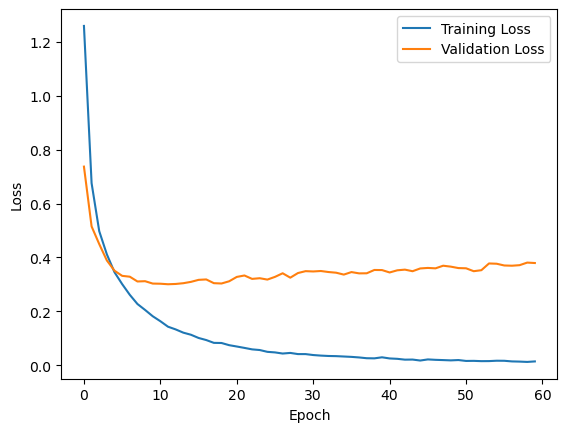

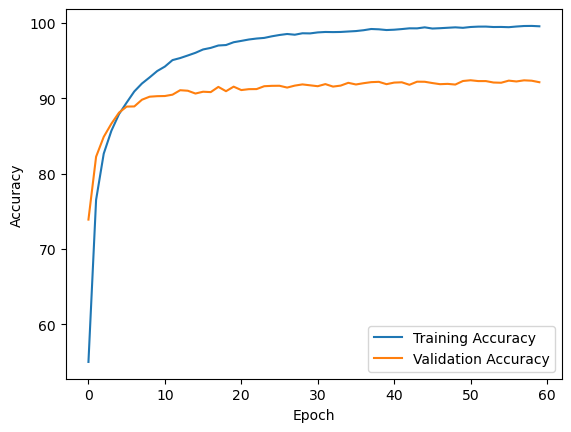

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


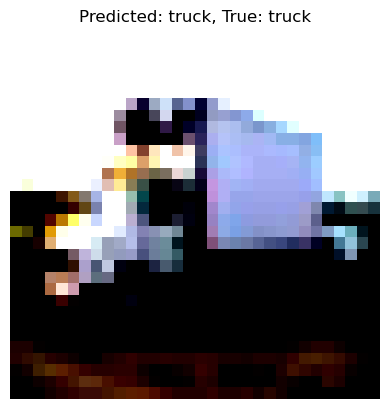

Predicted label:  truck
Actual label:  truck
Generating Visualization Plot


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


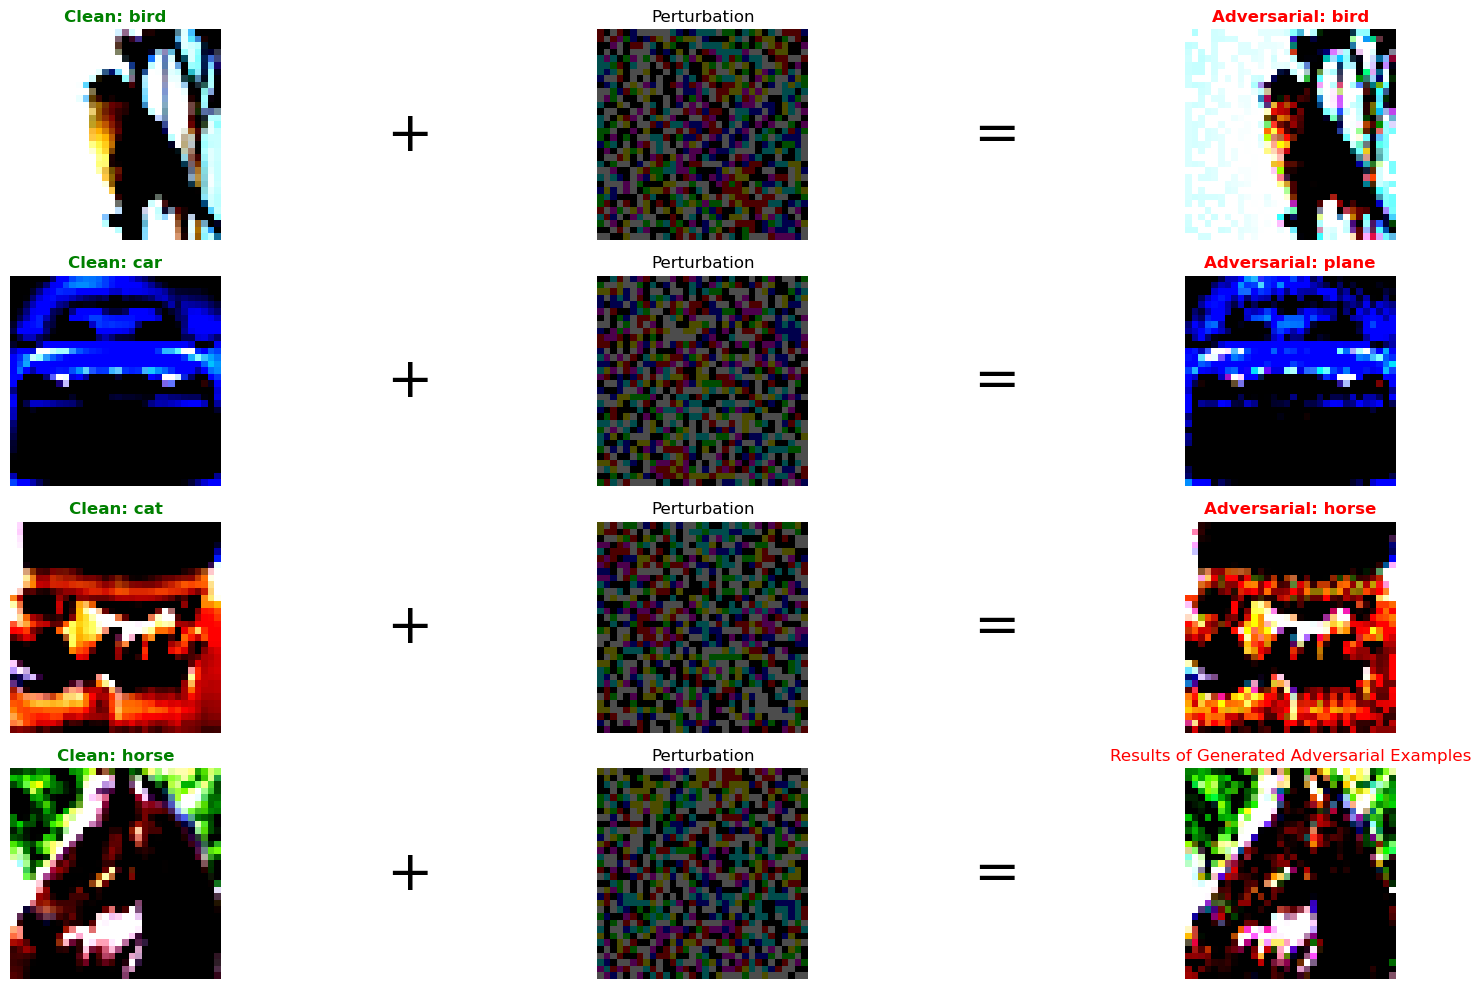

Files already downloaded and verified
Files already downloaded and verified
Best Trained Model Loaded!
Checkpoint at Epoch 51 with accuracy of 92.37%
Testing with clean data again to compare with checkpoint accuracy...
Clean Adv Accuracy: 92.37%
Clean Attack Success Rate: 7.63%
Matches with the Checkpoint Accuracy!
-----------------------------
Testing with adversarial examples...
Epsilon = 0.01:
Adversarial Accuracy: 52.51%
Attack Success Rate: 47.49%
------------------------------------------------------
Epsilon = 0.03:
Adversarial Accuracy: 49.23%
Attack Success Rate: 50.77%
------------------------------------------------------
Epsilon = 0.07:
Adversarial Accuracy: 43.54%
Attack Success Rate: 56.46%
------------------------------------------------------
Epsilon = 0.1:
Adversarial Accuracy: 40.34%
Attack Success Rate: 59.66%
------------------------------------------------------
Epsilon = 0.3:
Adversarial Accuracy: 29.65%
Attack Success Rate: 70.35%
---------------------------------

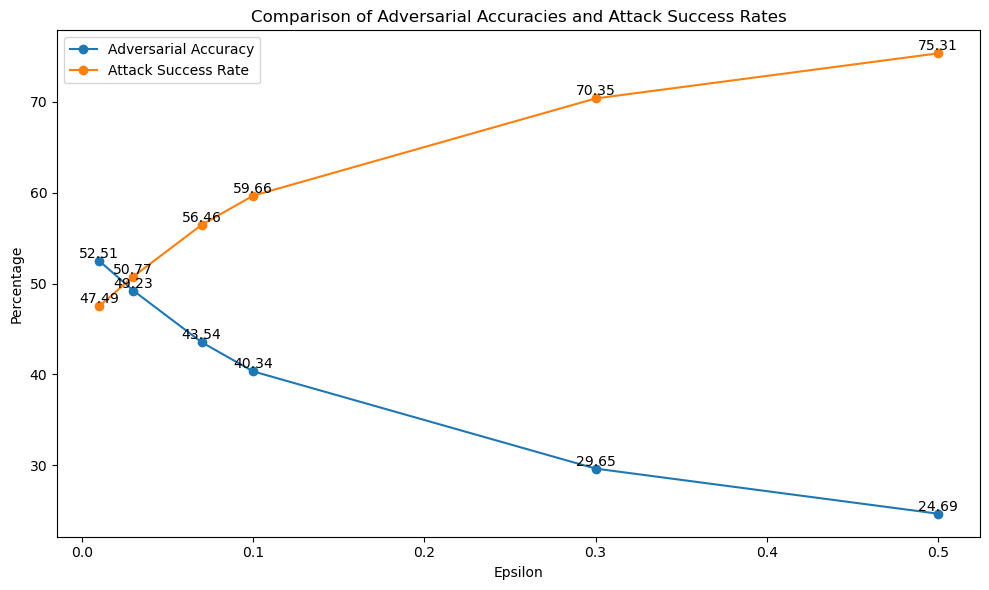

In [17]:
if __name__ == '__main__':
    main(train_model=True, epsilon_list=False)
    main(train_model=False, epsilon_list=True)

In [20]:
import os
import torch
import torchvision.utils as vutils
import shutil

def fgsm_attack(model, criterion, images, labels, device, epsilon):
    images.requires_grad_(True)
    outputs = model(images)
    loss = criterion(outputs, labels).to(device)
    model.zero_grad()
    loss.backward()

    gradient = images.grad.data
    perturbations = epsilon * torch.sign(gradient)
    adversarial_images = images + perturbations
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Generate adversarial images
adversarial_images = fgsm_attack(model, criterion, testset.data[:1000], testset.targets[:1000], device, epsilon)

# Save adversarial images
save_dir = './adversarial_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
for i, img in enumerate(adversarial_images):
    vutils.save_image(img, os.path.join(save_dir, f'adversarial_image_{i}.png'))

# Create a zip file of the directory
def create_zip(source_dir, zip_filename):
    shutil.make_archive(zip_filename, 'zip', source_dir)
    return f"{zip_filename}.zip"

# Call the function to create the zip file
zip_filename = 'adversarial_images'
zip_file_path = create_zip('./adversarial_images', zip_filename)

# Output the zip file name
print("Download the zip file containing the adversarial images:")
print(zip_file_path)


NameError: name 'criterion' is not defined